In [32]:
del model
torch.cuda.empty_cache()


In [33]:
# Core
import os, math, time, json, random, warnings
import numpy as np
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Vision
from PIL import Image, ImageFile
import torchvision.transforms as T

# Models / metrics / plotting
import timm
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

# Safety for partially corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True
warnings.filterwarnings("ignore", category=UserWarning)

# Reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
seed_everything(123)

# Paths (edit to your project layout)
DATA_DIR   = "."                             # base project dir
CSV_DIR    = os.path.join(DATA_DIR, "csvs")  # where train/val/test csvs live
RUNS_DIR   = os.path.join(DATA_DIR, "runs_03")
XAI_DIR    = os.path.join(RUNS_DIR, "wgt_test_xai")
os.makedirs(RUNS_DIR, exist_ok=True)
os.makedirs(XAI_DIR, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [34]:
from pathlib import Path

# Detect project root (same rule as your old notebook)
CWD = Path.cwd()
PROJECT_DIR = CWD.parent if CWD.name == "notebooks" else CWD

# Define run/output dirs as Path objects (not strings)
RUNS_DIR = PROJECT_DIR / "runs_03"
XAI_DIR  = RUNS_DIR / "wgt_test_xai_run2"

# Make sure they exist
RUNS_DIR.mkdir(parents=True, exist_ok=True)
XAI_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_DIR:", PROJECT_DIR)
print("RUNS_DIR   :", RUNS_DIR)
print("XAI_DIR    :", XAI_DIR)


PROJECT_DIR: /home/noushath/NSResearch/ASLR
RUNS_DIR   : /home/noushath/NSResearch/ASLR/runs_03
XAI_DIR    : /home/noushath/NSResearch/ASLR/runs_03/wgt_test_xai_run2


In [35]:
# --- Robust CSV discovery with pathlib ---
import pandas as pd

def has_all_csvs(d: Path) -> bool:
    return (d / "train.csv").exists() and (d / "val.csv").exists() and (d / "test.csv").exists()

# Prefer your legacy layout first, then fallbacks
candidates = [
    PROJECT_DIR / "splits",          # old layout
    PROJECT_DIR / "csvs",            # new layout
    PROJECT_DIR / "data" / "splits",
    PROJECT_DIR / "data" / "csvs",
]

CSV_DIR = None
for d in candidates:
    if has_all_csvs(d):
        CSV_DIR = d
        break

if CSV_DIR is None:
    # Shallow search as a fallback
    train_hits = list(PROJECT_DIR.rglob("train.csv"))
    val_hits   = list(PROJECT_DIR.rglob("val.csv"))
    test_hits  = list(PROJECT_DIR.rglob("test.csv"))
    parents = set(p.parent for p in train_hits) & set(p.parent for p in val_hits) & set(p.parent for p in test_hits)
    if parents:
        CSV_DIR = sorted(parents, key=lambda p: len(p.parts))[0]

if CSV_DIR is None:
    raise FileNotFoundError(
        "Could not locate train.csv/val.csv/test.csv.\n"
        f"Tried: {[str(p) for p in candidates]}\n"
        "Set CSV_DIR manually, e.g. CSV_DIR = Path('/path/to/splits')"
    )

print("Using CSV_DIR:", CSV_DIR)

# Load CSVs
train_csv = CSV_DIR / "train.csv"
val_csv   = CSV_DIR / "val.csv"
test_csv  = CSV_DIR / "test.csv"

df_tr = pd.read_csv(train_csv)
df_va = pd.read_csv(val_csv)
df_te = pd.read_csv(test_csv)

# Build label space
classes = sorted(df_tr["label"].unique().tolist())
cls_to_idx = {c:i for i,c in enumerate(classes)}
idx_to_cls = {i:c for c,i in cls_to_idx.items()}
num_classes = len(classes)

print(f"#classes: {num_classes}")
print("Example classes:", classes[:10])


Using CSV_DIR: /home/noushath/NSResearch/ASLR/splits
#classes: 31
Example classes: ['Ain', 'Al', 'Alef', 'Beh', 'Dad', 'Dal', 'Feh', 'Ghain', 'Hah', 'Heh']


In [36]:
# Augmentations — conservative for ASL (avoid horizontal flips)
IMG_SIZE = 224
train_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),              # keep geometry stable
    T.ColorJitter(brightness=0.15, contrast=0.10, saturation=0.10, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])
test_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

class ImageCSVDataset(Dataset):
    def __init__(self, df, transform, cls_to_idx):
        self.df = df.reset_index(drop=True)
        self.tfm = transform
        self.cls_to_idx = cls_to_idx

    def __len__(self):
        return len(self.df)

    def __getitem__(self, i):
        row = self.df.iloc[i]
        path = row["image_path"]
        label_str = row["label"]
        y = self.cls_to_idx[label_str]
        # Robust image open
        try:
            x = Image.open(path).convert("RGB")
        except Exception as e:
            # in rare cases of bad encodings, retry or raise
            x = Image.open(path).convert("RGB")
        x = self.tfm(x)
        return x, y, path

tr_ds = ImageCSVDataset(df_tr, train_tfms, cls_to_idx)
va_ds = ImageCSVDataset(df_va, test_tfms,  cls_to_idx)
te_ds = ImageCSVDataset(df_te, test_tfms,  cls_to_idx)

BATCH_SIZE = 32
NUM_WORKERS = 4

tr_ld = DataLoader(tr_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
va_ld = DataLoader(va_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
te_ld = DataLoader(te_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(tr_ds), len(va_ds), len(te_ds)


(5496, 1180, 1180)

In [29]:
# Cell 4 — Model: Swin-Tiny → proj(768→384) → Top-K(NMS) → [CLS]+pos → 2×GlobalViT → head (+aux scorer)

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm

class PositionalEmbedding2D(nn.Module):
    """Learned 2D positional embeddings for integer grid coords (y,x) on H×W."""
    def __init__(self, D=384, H=7, W=7):
        super().__init__()
        self.H, self.W = H, W
        self.emb = nn.Parameter(torch.zeros(1, H, W, D))
        nn.init.trunc_normal_(self.emb, std=0.02)

    def forward(self, coords_yx):
        """
        coords_yx: (B,K,2) with y∈[0..H-1], x∈[0..W-1]
        returns: (B,K,D)
        """
        y = coords_yx[..., 0].clamp(0, self.H-1).long()
        x = coords_yx[..., 1].clamp(0, self.W-1).long()
        return self.emb[0, y, x, :]

class TopKTokenBridge(nn.Module):
    """
    Diversity-aware Top-K selection via greedy grid-NMS on a given score map.
    Inputs:
        imp_map   : (B,H,W) class-conditioned scores (higher is better)
        tokens    : (B,N,D) token embeddings (N=H*W)
    Returns:
        sel_tokens: (B,K,D)
        sel_coords: (B,K,2) integer (y,x)
        imp_map   : (B,H,W) (passed through for XAI)
    """
    def __init__(self, topk: int = 16, nms_radius: int = 1, use_hand_prior: bool = False):
        super().__init__()
        self.topk = topk
        self.nms_radius = nms_radius
        self.use_hand_prior = use_hand_prior  # hook; pass prior_7x7 if you enable it

    @torch.no_grad()
    def _nms_indices(self, score_map: torch.Tensor, K: int, radius: int = 1):
        H, W = score_map.shape
        cap = math.ceil(H/(radius+1)) * math.ceil(W/(radius+1))  # lattice max
        K_eff = min(K, cap)
        scr = score_map.clone()
        NEG = -1e9
        picks = []
        for _ in range(K_eff):
            val = torch.max(scr).item()
            if val <= -1e8:
                break  # fully suppressed
            idx = torch.argmax(scr).item()
            y, x = divmod(idx, W)
            picks.append((y, x))
            y0, y1 = max(0, y-radius), min(H, y+radius+1)
            x0, x1 = max(0, x-radius), min(W, x+radius+1)
            scr[y0:y1, x0:x1] = NEG
        # If we somehow picked fewer than K (rare with 7×7,r=1,K=16), fill deterministically on a 2-stride lattice
        if len(picks) < K_eff:
            chosen = set(picks)
            lattice = [(yy, xx) for yy in [0,2,4,6] for xx in [0,2,4,6] if yy < H and xx < W]
            # rank lattice cells by score
            cand = sorted(lattice, key=lambda yz: score_map[yz[0], yz[1]].item(), reverse=True)
            for yy, xx in cand:
                if len(picks) >= K_eff: break
                if (yy, xx) not in chosen:
                    picks.append((yy, xx)); chosen.add((yy, xx))
        return picks

    def forward(self, imp_map, tokens, H, W, prior_7x7=None):
        # Optional prior (off by default)
        if self.use_hand_prior and (prior_7x7 is not None):
            beta = 0.5
            imp_map = imp_map + beta * (prior_7x7 - 0.5)

        B = tokens.size(0)
        sel_list, coord_list = [], []
        for b in range(B):
            picks = self._nms_indices(imp_map[b].detach().cpu(), self.topk, radius=self.nms_radius)
            idxs  = torch.tensor([py*W + px for (py,px) in picks], device=tokens.device, dtype=torch.long)
            sel_list.append(tokens[b, idxs, :])                         # (K,D)
            coord_list.append(torch.tensor(picks, device=tokens.device))# (K,2)
        return torch.stack(sel_list,0), torch.stack(coord_list,0), imp_map

class TinyGlobalViTBlock(nn.Module):
    """A compact transformer encoder block (supports fixed K; no pad mask needed here)."""
    def __init__(self, D=384, heads=6, mlp_ratio=4, p_drop=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(D)
        self.attn  = nn.MultiheadAttention(D, heads, batch_first=True)
        self.drop1 = nn.Dropout(p_drop)
        self.norm2 = nn.LayerNorm(D)
        self.mlp   = nn.Sequential(
            nn.Linear(D, D*mlp_ratio), nn.GELU(), nn.Dropout(p_drop),
            nn.Linear(D*mlp_ratio, D), nn.Dropout(p_drop)
        )
    def forward(self, x):
        h,_ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + self.drop1(h)
        x = x + self.mlp(self.norm2(x))
        return x

class WGT_ArSL(nn.Module):
    """
    Swin-Tiny (features_only, final 7×7×768) → proj(768→384) → score vs [CLS] → TopK(NMS, K=16)
    → add 2D pos → 2×GlobalViT → linear head. Plus an auxiliary soft-attention head to shape scores.
    """
    def __init__(self, num_classes, K=16, D=384, use_hand_prior=False):
        super().__init__()
        # Local encoder: final stage features (B,768,7,7) or (B,7,7,768) depending on memory format
        self.backbone = timm.create_model(
            "swin_tiny_patch4_window7_224", pretrained=True, features_only=True, out_indices=[3]
        )
        self.proj   = nn.Linear(768, D)
        self.scorer = nn.Linear(D, D, bias=False)      # trainable scorer (shaped via aux loss)
        self.cls_token = nn.Parameter(torch.zeros(1,1,D))
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        self.bridge = TopKTokenBridge(topk=K, nms_radius=1, use_hand_prior=use_hand_prior)
        self.pos2d  = PositionalEmbedding2D(D=D, H=7, W=7)

        # Tiny global transformer
        self.block1 = TinyGlobalViTBlock(D=D, heads=6, mlp_ratio=4, p_drop=0.0)
        self.block2 = TinyGlobalViTBlock(D=D, heads=6, mlp_ratio=4, p_drop=0.0)

        self.head     = nn.Linear(D, num_classes)  # main classifier
        self.aux_head = nn.Linear(D, num_classes)  # auxiliary head (for score shaping)
        self.score_tau = 0.5                       # temperature for soft selection (aux loss)

    def forward(self, x, return_explain=False, prior_7x7=None):
        B = x.size(0)

        # Stage A: local features; normalize to (B,C,H,W) if needed
        feats = self.backbone(x)[0]  # possibly (B,768,7,7) or (B,7,7,768)
        if feats.ndim != 4:
            raise RuntimeError(f"Backbone returned unexpected ndim={feats.ndim}")
        if feats.shape[1] not in (96,192,384,768) and feats.shape[-1] in (96,192,384,768):
            feats = feats.permute(0,3,1,2).contiguous()  # NHWC → NCHW

        B, C, H, W = feats.shape  # expected (B,768,7,7)

        # Tokens and projection to D
        tokens = feats.flatten(2).transpose(1,2)   # (B,N=H*W,C)
        tokens = self.proj(tokens)                 # (B,N,D)

        # Class-conditioned scores vs [CLS]
        cls = self.cls_token.expand(B, -1, -1)     # (B,1,D)
        s = F.normalize(self.scorer(tokens), dim=-1)  # (B,N,D)
        q = F.normalize(cls, dim=-1)                 # (B,1,D)
        imp = (s * q).sum(-1)                        # (B,N)
        imp_map = imp.reshape(B, H, W)               # (B,H,W)

        # Auxiliary soft-attention head (training-time supervision for the scorer)
        w_soft = F.softmax(imp / self.score_tau, dim=1)       # (B,N)
        z_soft = torch.einsum('bn,bnd->bd', w_soft, tokens)   # (B,D)
        logits_aux = self.aux_head(z_soft)                    # (B,C)

        # Bridge: Top-K selection (diversity via grid-NMS)
        sel_tokens, sel_coords, heatmap = self.bridge(imp_map, tokens, H, W, prior_7x7=prior_7x7)  # (B,K,D),(B,K,2),(B,H,W)

        # Add 2D positional embedding, then global tiny ViT over [CLS] + K tokens
        pos = self.pos2d(sel_coords)               # (B,K,D)
        sel_tokens = sel_tokens + pos
        xg = torch.cat([cls, sel_tokens], dim=1)   # (B,1+K,D)
        xg = self.block1(xg)
        xg = self.block2(xg)

        # Readout
        h_cls = xg[:, 0, :]
        logits = self.head(h_cls)                  # (B,num_classes)

        if return_explain:
            return logits, {
                "heatmap": heatmap.detach(),       # (B,H,W)
                "sel_coords": sel_coords.detach(), # (B,K,2)
                "logits_aux": logits_aux           # (B,C) for aux loss in training
            }
        return logits


In [40]:
model = WGT_ArSL(num_classes=num_classes, K=16, D=384, use_hand_prior=False).to(device)

# Class weights (optional; helpful for imbalance)
y_counts = df_tr["label"].value_counts()
weights = torch.tensor([1.0 / y_counts[idx_to_cls[i]] for i in range(num_classes)], dtype=torch.float32)
weights = (weights / weights.mean()).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

print(sum(p.numel() for p in model.parameters())/1e6, "M params")


31.552568 M params


/tmp/ipykernel_75077/204327381.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


In [41]:
model.eval()
with torch.no_grad():
    xb, yb, _ = next(iter(tr_ld))
    out = model(xb.to(device)[:2], return_explain=True)
    if isinstance(out, tuple) and isinstance(out[1], dict):
        logits, expl = out
        print("Expl keys:", list(expl.keys()))
    else:
        print("Model returned no expl dict; only logits.")


Expl keys: ['heatmap', 'sel_coords', 'logits_aux']


In [39]:
print({"K": model.bridge.topk, "score_tau": getattr(model,"score_tau",None)})


{'K': 16, 'score_tau': 0.5}


In [42]:
# Cell 6 — Train/Validate with auxiliary scorer loss and checkpointing (macro-F1 focus)

LAMBDA_AUX = 0.20
EPOCHS = 15

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    y_true, y_pred = [], []

    for x, y, _ in loader:
        x = x.to(device)
        y = torch.as_tensor(y, dtype=torch.long, device=device)

        with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
            if train:
                out = model(x, return_explain=True)
                # unpack robustly
                if isinstance(out, tuple) and len(out) == 2 and isinstance(out[1], dict):
                    logits, expl = out
                    logits_aux = expl.get("logits_aux", None)
                else:
                    logits, logits_aux = out, None

                loss = criterion(logits, y)
                if logits_aux is not None:
                    loss = loss + LAMBDA_AUX * nn.functional.cross_entropy(logits_aux, y)
            else:
                logits = model(x)
                loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(optimizer); scaler.update()

        total_loss += float(loss.item()) * x.size(0)
        y_true.extend(y.detach().cpu().tolist())
        y_pred.extend(logits.argmax(dim=-1).detach().cpu().tolist())

    macro_f1 = f1_score(y_true, y_pred, average="macro")
    acc = (np.array(y_true) == np.array(y_pred)).mean()
    return total_loss / len(loader.dataset), acc, macro_f1

best_f1 = -1.0
for ep in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc, tr_f1 = run_epoch(tr_ld, train=True)
    va_loss, va_acc, va_f1 = run_epoch(va_ld, train=False)
    scheduler.step()
    print(f"Epoch {ep:02d} | train {tr_loss:.4f}/{tr_acc:.3f}/{tr_f1:.3f} | "
          f"val {va_loss:.4f}/{va_acc:.3f}/{va_f1:.3f} | {(time.time()-t0)/60:.1f} min")

    if va_f1 > best_f1:
        best_f1 = va_f1
        torch.save({
            "model": model.state_dict(),
            "classes": classes,
            "config": {"K":16, "D":384, "backbone":"swin_tiny_patch4_window7_224",
                       "lambda_aux": LAMBDA_AUX, "score_tau": getattr(model, "score_tau", None)}
        }, RUNS_DIR / "wgt_arsl_best.pt")

print("Best val macro-F1:", best_f1)



/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01 | train 1.5915/0.589/0.587 | val 0.7763/0.733/0.724 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 02 | train 0.5471/0.859/0.858 | val 0.4359/0.884/0.875 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 03 | train 0.3582/0.908/0.907 | val 0.2837/0.921/0.921 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 04 | train 0.2525/0.938/0.938 | val 0.2826/0.921/0.919 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 05 | train 0.1965/0.955/0.954 | val 0.1954/0.950/0.950 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 06 | train 0.1573/0.967/0.966 | val 0.2622/0.948/0.946 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 07 | train 0.1080/0.978/0.978 | val 0.2270/0.956/0.957 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 08 | train 0.0881/0.986/0.986 | val 0.3253/0.962/0.961 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 09 | train 0.0616/0.990/0.990 | val 0.3202/0.964/0.964 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 10 | train 0.0353/0.996/0.997 | val 0.3077/0.968/0.967 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 11 | train 0.0213/0.998/0.998 | val 0.3235/0.970/0.970 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 12 | train 0.0151/0.999/0.999 | val 0.1914/0.984/0.983 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 13 | train 0.0116/0.999/0.999 | val 0.2083/0.981/0.981 | 2.1 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 14 | train 0.0068/0.999/0.999 | val 0.2169/0.984/0.983 | 2.2 min


/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):
/tmp/ipykernel_75077/4131130538.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.set_grad_enabled(train), torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 15 | train 0.0075/1.000/1.000 | val 0.2181/0.984/0.983 | 2.2 min
Best val macro-F1: 0.9832857112957176


,precision,recall,f1-score,support
Ain,1.000000,1.000000,1.000000,37.000000
Al,1.000000,1.000000,1.000000,41.000000
Alef,0.977273,1.000000,0.988506,43.000000
Beh,0.978261,0.978261,0.978261,46.000000
Dad,1.000000,1.000000,1.000000,40.000000
Dal,0.945946,1.000000,0.972222,35.000000
Feh,1.000000,0.868421,0.929577,38.000000
Ghain,1.000000,0.970588,0.985075,34.000000
Hah,0.973684,1.000000,0.986667,37.000000
Heh,1.000000,0.973684,0.986667,38.000000


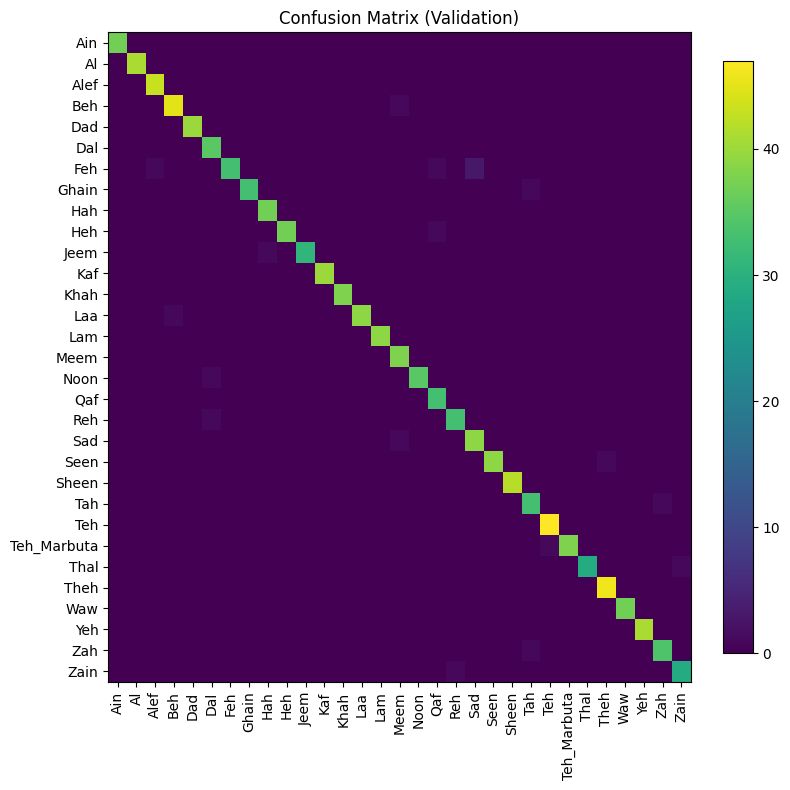

In [43]:
ckpt = torch.load(os.path.join(RUNS_DIR, "wgt_arsl_best.pt"), map_location=device)
model.load_state_dict(ckpt["model"])

# Evaluate on validation (or test) and print per-class metrics
def evaluate(loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            logits = model(x)
            y_pred.extend(logits.argmax(dim=-1).cpu().numpy().tolist())
            y_true.extend(y)
    report = classification_report(y_true, y_pred, target_names=classes, digits=4, output_dict=True)
    return report, y_true, y_pred

report_va, y_true_va, y_pred_va = evaluate(va_ld)
df_rep = pd.DataFrame(report_va).T
display(df_rep[["precision","recall","f1-score","support"]])

# Confusion matrix plot
cm = confusion_matrix(y_true_va, y_pred_va, labels=list(range(num_classes)))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(cm, interpolation='nearest', aspect='auto')
ax.set_title("Confusion Matrix (Validation)")
plt.colorbar(im, ax=ax, fraction=0.046)
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(classes, rotation=90); ax.set_yticklabels(classes)
plt.tight_layout()
plt.show()


In [44]:
# Cell 8 — XAI utilities (smooth overlays; no OpenCV; NumPy 2.0 safe)

import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def grid_coord_to_pixel(y, x, img_wh=224, H=7, W=7):
    """Map grid cell (y,x) in H×W to pixel-center in img_wh×img_wh image."""
    step_y = img_wh / H; step_x = img_wh / W
    cy = (y + 0.5) * step_y; cx = (x + 0.5) * step_x
    return int(round(cx)), int(round(cy))

def _gaussian_kernel(size=9, sigma=1.5, device="cpu"):
    ax = torch.arange(size, device=device) - (size - 1)/2
    xx, yy = torch.meshgrid(ax, ax, indexing="xy")
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma**2))
    return k / k.sum()

def save_xai_overlay(x_tensor, logits, expl, out_path, alpha=0.45):
    """
    Save heatmap + dots overlay.
      x_tensor: (3,224,224) normalized to [-1,1]
      expl: {'heatmap': (1,H,W), 'sel_coords': (1,K,2)}
    """
    # Denormalize image for display
    x = x_tensor.detach().cpu().float()
    x = (x * 0.5 + 0.5).clamp(0,1)
    base = (x.permute(1,2,0).numpy() * 255).astype(np.uint8)  # (224,224,3)

    # Heatmap: (H,W) → (224,224) with bicubic + gentle Gaussian blur to deblock
    heat = expl["heatmap"][0].detach().cpu()[None,None,:,:]  # (1,1,H,W), H=W=7 by default
    heat_up = F.interpolate(heat, size=(224,224), mode="bicubic", align_corners=True)  # (1,1,224,224)
    k = _gaussian_kernel(size=9, sigma=1.5, device=heat_up.device)[None,None,:,:]
    heat_smooth = F.conv2d(heat_up, k, padding=4)  # (1,1,224,224)
    heat_map = heat_smooth[0,0].cpu().numpy()

    # Normalize (NumPy 2.0 safe)
    denom = np.ptp(heat_map)  # max - min
    if denom < 1e-12:
        heat_norm = np.zeros_like(heat_map, dtype=np.float32)
    else:
        heat_norm = (heat_map - heat_map.min()) / (denom + 1e-12)

    # Colorize with matplotlib JET
    cmap = plt.get_cmap("jet")
    heat_color = (cmap(heat_norm)[..., :3] * 255).astype(np.uint8)  # RGB

    # Blend
    overlay = (alpha * heat_color.astype(np.float32) + (1 - alpha) * base.astype(np.float32)).astype(np.uint8)

    # Draw selected token dots
    coords = expl["sel_coords"][0].detach().cpu().numpy()  # (K,2) as (y,x)
    ov_img = Image.fromarray(overlay, mode="RGB")
    draw = ImageDraw.Draw(ov_img)
    for (yy, xx) in coords:
        cx, cy = grid_coord_to_pixel(int(yy), int(xx), img_wh=224, H=heat.shape[-2], W=heat.shape[-1])
        r_in, r_out = 5, 7
        draw.ellipse([cx-r_in, cy-r_in, cx+r_in, cy+r_in], fill=(255,255,255))
        draw.ellipse([cx-r_out, cy-r_out, cx+r_out, cy+r_out], outline=(0,0,0), width=1)

    ov_img.save(out_path)

# Quick sanity check on one validation sample
model.eval()
with torch.no_grad():
    x_val, y_val, p_val = next(iter(va_ld))
    x1 = x_val.to(device)[:1]
    logits1, expl1 = model(x1, return_explain=True)

out_test = XAI_DIR / "sanity_xai.png"
save_xai_overlay(x_val[0].cpu(), logits1[0:1], expl1, out_test)
print("Saved:", out_test)


Saved: /home/noushath/NSResearch/ASLR/runs_03/wgt_test_xai_run2/sanity_xai.png


In [45]:
model.eval()
n_saved = 0
with torch.no_grad():
    for x, y, paths in te_ld:
        x = x.to(device)
        logits, expl = model(x, return_explain=True)
        for i in range(x.size(0)):
            fn = os.path.basename(paths[i])
            out_path = os.path.join(XAI_DIR, f"{fn}_xai.png")
            save_xai_overlay(x[i].cpu(), logits[i:i+1], {"heatmap": expl["heatmap"][i:i+1],
                                                         "sel_coords": expl["sel_coords"][i:i+1]}, out_path)
            n_saved += 1
print("Saved overlays:", n_saved, "→", XAI_DIR)


Saved overlays: 1180 → /home/noushath/NSResearch/ASLR/runs_03/wgt_test_xai_run2


In [ ]:
report_te, y_true_te, y_pred_te = evaluate(te_ld)
df_rep_te = pd.DataFrame(report_te).T
display(df_rep_te[["precision","recall","f1-score","support"]])

acc = (np.array(y_true_te) == np.array(y_pred_te)).mean()
macro_f1 = f1_score(y_true_te, y_pred_te, average="macro")
print({"acc": acc, "macro_f1": macro_f1, "num_test": len(te_ds)})
